In [1]:
import pandas as pd
import numpy as np
from tensorflow.python.ops import nn_ops, gen_nn_ops
import tensorflow as tf

In [2]:
class CNN_MC_dropout:
    def __init__(self, std=0.01, batch_size=64,width=500, height =1, input_channel=3, nb_classes=2, l_rate =1e-6,reuse = False):
        self.std=std
        self.batch_size=batch_size
        self.height = height
        self.width = width
        self.input_channel = input_channel
        self.l_rate = l_rate
        
        self.nb_classes = nb_classes

        with tf.name_scope('Classifier'):
            self.y = tf.placeholder(tf.float32, [None, self.nb_classes], name='y')
            self.x = tf.placeholder(tf.float32, [None, self.height,self.width,self.input_channel], name='x')
            self.keep_prob = tf.placeholder(tf.float32)
            self.is_dropout = tf.placeholder(tf.bool)
        
        # keep prob가 1보다 작으면, 드랍아웃을 한다는 의미
        #self.dropout_bool = True#tf.cond(self.keep_prob < 1.0, lambda: tf.constant(True), lambda: tf.constant(False))
        
        self.logits = self.build_model()

        # Define loss and optimizer, minimize the squared error
        self.cross_entropy =  tf.nn.softmax_cross_entropy_with_logits_v2(labels=self.y, logits=self.logits)
        self.cost =tf.reduce_mean(self.cross_entropy)
        self.optimizer = tf.train.AdamOptimizer(self.l_rate).minimize(self.cost)

        self.correct_pred = tf.equal(tf.round(self.prediction),self.y)
        self.accuracy = tf.reduce_mean(tf.cast(self.correct_pred, tf.float32))

        init = tf.global_variables_initializer()

        # Launch the session
        self.session_conf = tf.ConfigProto()
        self.session_conf.gpu_options.allow_growth = True
        self.sess = tf.InteractiveSession(config=self.session_conf)
        self.sess.run(init)

        self.saver = tf.train.Saver(max_to_keep=None)

    def build_model(self):
        with tf.variable_scope('layer0'):
            #b, h, w, c
            self.input = self.x
        # Convolutional Layer #1 and Pooling Layer #1
        with tf.variable_scope('layer1'):
            self.conv1 = tf.layers.conv2d(self.input, 128, [8,1], padding='SAME')
            self.batch1 = tf.layers.batch_normalization(self.conv1)
            self.relu1 = tf.nn.relu(self.batch1)
            self.dropout1 = tf.nn.dropout(self.relu1, self.keep_prob)

        # Convolutional Layer #1 and Pooling Layer #2
        with tf.variable_scope('layer2'):
            self.conv2 = tf.layers.conv2d(self.dropout1, 256, [5,1], padding='SAME')
            self.batch2 = tf.layers.batch_normalization(self.conv2)
            self.relu2 = tf.nn.relu(self.batch2)
            self.dropout2 = tf.nn.dropout(self.relu2, self.keep_prob)

        # Convolutional Layer #1 and Pooling Layer #3
        with tf.variable_scope('layer3'):
            self.conv3 = tf.layers.conv2d(self.dropout2, 128, [3,1], padding='SAME')
            self.batch3 = tf.layers.batch_normalization(self.conv3)
            self.relu3 = tf.nn.relu(self.batch3)

        # Dense Layer with Relu
        with tf.variable_scope('layer4'):
            #Global Average Pooling
            self.GAP = tf.reduce_mean(self.relu3, axis=[1,2])# b,h,w,c
            self.logits = tf.layers.dense(self.GAP,self.nb_classes)
            self.prediction = tf.nn.softmax(self.logits)
            
        return self.logits


    def train(self, data, target, keep_prob,is_dropout):
        opt, cost ,acc = self.sess.run((self.optimizer, self.cost, self.accuracy ), 
                             feed_dict={self.y: target,
                                        self.x: data,
                                       self.keep_prob: keep_prob,
                                       self.is_dropout : is_dropout})
        return cost,acc

    def test(self, data, target, keep_prob,is_dropout):
        cost,acc = self.sess.run((self.cost,self.accuracy),
                             feed_dict={self.y: target,
                                        self.x: data,
                                       self.keep_prob: keep_prob,
                                       self.is_dropout : is_dropout})
        return cost,acc

    def get_last_conv_output(self, data, keep_prob,is_dropout):
        relu3 =  self.sess.run((self.relu3), 
                             feed_dict={self.x: data,
                                       self.keep_prob: keep_prob,
                                       self.is_dropout : is_dropout})
        return relu3
    
    def predict(self, data, keep_prob,is_dropout):

        prediction =  self.sess.run((self.prediction), 
                             feed_dict={self.x: data,
                                       self.keep_prob: keep_prob,
                                       self.is_dropout : is_dropout})
        return prediction

    def save(self, save_path='./model.ckpt'):
        saved_path = self.saver.save(self.sess, save_path)
        print("Model saved in file: %s"%saved_path)

    def load(self, load_path = './model.ckpt'):
        self.saver.restore(self.sess, load_path)
        print("Model restored")

    def terminate(self):
        self.sess.close()
        tf.reset_default_graph() 

# 1. Data Load
### 전처리 width, height, input_channel 정의

In [3]:
import os

In [4]:
def readucr(filename):
    data = np.loadtxt(filename)
    Y = data[:,0]
    X = data[:,1:]
    return X, Y

In [5]:
data_path ="./data"
fname = 'Trace'

In [6]:
full_data_path = os.path.join(data_path,fname)
if os.path.exists(full_data_path):
    x_train, y_train = readucr(full_data_path+'/'+fname+'_TRAIN.txt')
    x_test, y_test = readucr(full_data_path+'/'+fname+'_TEST.txt')
    nb_classes = len(np.unique(y_test))
    batch_size = min(int(x_train.shape[0]/10), 16)
    print ("batch size:{}".format(batch_size))

batch size:10


In [7]:
hot_encoded_y_train = np.asarray(pd.get_dummies(np.asarray(y_train)))
hot_encoded_y_test = np.asarray(pd.get_dummies(np.asarray(y_test)))

In [8]:
trainX = x_train[:, np.newaxis, :, np.newaxis]
trainY = hot_encoded_y_train

validX =x_test[:len(x_test)//2, np.newaxis, :, np.newaxis]
validY= hot_encoded_y_test[:len(x_test)//2]

testX = x_test[len(x_test)//2:, np.newaxis, :, np.newaxis]
testY = hot_encoded_y_test[len(x_test)//2:]

print ("trainX shape:{}".format(trainX.shape))
print ("trainY shape:{}".format(trainY.shape))
print ("validX shape:{}".format(validX.shape))
print ("validY shape:{}".format(validY.shape))
print ("testY shape:{}".format(testY.shape))
print ("testX shape:{}".format(testX.shape))
print ("testY shape:{}".format(testY.shape))

trainX shape:(100, 1, 275, 1)
trainY shape:(100, 4)
validX shape:(50, 1, 275, 1)
validY shape:(50, 4)
testY shape:(50, 4)
testX shape:(50, 1, 275, 1)
testY shape:(50, 4)


In [9]:
height = trainX.shape[1]
width = trainX.shape[2]
input_channel = trainX.shape[3]

# 2. Training condition 정의

In [10]:
t_loss=[]
t_acc=[]

v_loss=[]
v_acc=[]

val_freq = 1
save_freq = 1
num_epochs= 100


std= 0.01
l_rate = 1e-3

In [11]:
train_history = pd.DataFrame(index=np.arange(0, num_epochs), columns=['epoch', 'loss', 'acc','timestamp'])
valid_history = pd.DataFrame(index=np.arange(0, num_epochs/val_freq),columns=['epoch', 'loss', 'acc','timestamp'])

# 3. model structure 정의

In [12]:
if 'MC_dropout_model' in globals():
    MC_dropout_model.terminate()
    
MC_dropout_model =CNN_MC_dropout(height=height,width= width, input_channel=input_channel ,nb_classes=nb_classes,
                                 std=std,batch_size=batch_size,l_rate=l_rate)

In [13]:
print (MC_dropout_model.input)
print ('[layer1] - MC dropout')
print (MC_dropout_model.conv1)
print (MC_dropout_model.batch1)
print (MC_dropout_model.relu1)
print (MC_dropout_model.dropout1)
print ('[layer2] - MC dropout')
print (MC_dropout_model.conv2)
print (MC_dropout_model.batch2)
print (MC_dropout_model.relu2)
print (MC_dropout_model.dropout2)
print ('[layer3]')
print (MC_dropout_model.conv3)
print (MC_dropout_model.batch3)
print (MC_dropout_model.relu3)
print ('[layer4]')
print (MC_dropout_model.GAP)
print (MC_dropout_model.logits)

Tensor("Classifier/x:0", shape=(?, 1, 275, 1), dtype=float32)
[layer1] - MC dropout
Tensor("layer1/conv2d/BiasAdd:0", shape=(?, 1, 275, 128), dtype=float32)
Tensor("layer1/batch_normalization/FusedBatchNorm:0", shape=(?, 1, 275, 128), dtype=float32)
Tensor("layer1/Relu:0", shape=(?, 1, 275, 128), dtype=float32)
Tensor("layer1/dropout/mul:0", shape=(?, 1, 275, 128), dtype=float32)
[layer2] - MC dropout
Tensor("layer2/conv2d/BiasAdd:0", shape=(?, 1, 275, 256), dtype=float32)
Tensor("layer2/batch_normalization/FusedBatchNorm:0", shape=(?, 1, 275, 256), dtype=float32)
Tensor("layer2/Relu:0", shape=(?, 1, 275, 256), dtype=float32)
Tensor("layer2/dropout/mul:0", shape=(?, 1, 275, 256), dtype=float32)
[layer3]
Tensor("layer3/conv2d/BiasAdd:0", shape=(?, 1, 275, 128), dtype=float32)
Tensor("layer3/batch_normalization/FusedBatchNorm:0", shape=(?, 1, 275, 128), dtype=float32)
Tensor("layer3/Relu:0", shape=(?, 1, 275, 128), dtype=float32)
[layer4]
Tensor("layer4/Mean:0", shape=(?, 128), dtype=flo

# 4. Training

In [14]:
import time

In [15]:
save_path = './savedmodel'
model_name = 'ICML(UCR-'+fname+')_CNN_MCdropout_'+str(l_rate)+'_'+str(batch_size)
print (model_name)

ICML(UCR-Trace)_CNN_MCdropout_0.001_10


In [16]:
def get_batch(X, Y,  batch_size=1024, shuffle=False):
    """
    dataset: numpy ndarray. dim=2
    
    dataset_input = normalized_data[:, input_idx]
    dataset_target = normalized_data[:, target_idx]
    interested_indices = train_indices
    """    
    assert np.isnan(X).any()==False
    assert np.isnan(Y).any()==False
    
    interested_indices = range(0,len(X))

    if shuffle:
        np.random.shuffle(interested_indices)
        
    for i in range(0, len(X)-batch_size, batch_size):
        batch_Xlist = []
        batch_Ylist = [] 
        
        batch_indices = interested_indices[i:i+batch_size]

        batch_Xlist.append(X[batch_indices])
        batch_Ylist.append(Y[batch_indices])

            
        batch_Xlist = np.asarray(batch_Xlist)
        batch_Xlist = batch_Xlist.reshape(-1,X.shape[1],X.shape[2],X.shape[3])
        
        batch_Ylist = np.asarray(batch_Ylist)
        batch_Ylist = batch_Ylist.reshape(-1,nb_classes)

        yield batch_Xlist, batch_Ylist

In [17]:
keep_prob =1.0

In [18]:
for epoch in range(num_epochs):#range(num_epochs):##
    
    loss = 0
    acc=0
    train_batches = 0
    start_time = time.time()   
    
    for batch in get_batch(X=trainX, Y=trainY, batch_size=batch_size):
        train_in, train_target = batch
        train_batches += 1.0 
        loss1 ,acc1 = MC_dropout_model.train(data=train_in,target= train_target,keep_prob=keep_prob,is_dropout=False)
        loss = loss1+loss
        acc = acc1+acc
        if np.isnan(loss):
            print ('error')
            break
    t_loss.append(loss/train_batches)
    t_acc.append(acc/train_batches)
    
    train_history.loc[epoch] = [epoch+1, t_loss[epoch], t_acc[epoch] ,time.strftime("%Y-%m-%d-%H:%M", time.localtime())]
    if not os.path.exists(os.path.join(save_path, model_name)):
        os.mkdir( os.path.join(save_path, model_name))
    MC_dropout_model.save(os.path.join(save_path, model_name,str(epoch+1)+'.ckpt'))

    
    if(epoch+1)%val_freq ==0:
        acc=0
        loss = 0
        val_batches=0
        for batch in get_batch(X=validX, Y=validY, batch_size=batch_size):
            val_in, val_target = batch
            val_batches += 1.0 
            loss1 ,acc1 = MC_dropout_model.test(data=val_in,target= val_target,keep_prob=keep_prob,is_dropout=False)
            loss = loss1+loss
            acc = acc1+acc
        
        v_acc.append(acc/val_batches)
        v_loss.append(loss/val_batches)
        valid_history.loc[epoch] = [epoch+1, v_loss[epoch], v_acc[epoch] ,time.strftime("%Y-%m-%d-%H:%M", time.localtime())]  
        
        print("  training loss:\t{:.6f}".format(t_loss[epoch]))
        print("  training acc:\t{:.3f}".format(t_acc[epoch]))
        print("  validation loss:\t{:.6f}".format(v_loss[epoch]))
        print("  validation acc:\t{:.3f}".format(v_acc[epoch]))


INFO:tensorflow:./savedmodel/ICML(UCR-Trace)_CNN_MCdropout_0.001_10/1.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./savedmodel/ICML(UCR-Trace)_CNN_MCdropout_0.001_10/1.ckpt
  training loss:	1.390007
  training acc:	0.750
  validation loss:	1.396183
  validation acc:	0.750
INFO:tensorflow:./savedmodel/ICML(UCR-Trace)_CNN_MCdropout_0.001_10/2.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./savedmodel/ICML(UCR-Trace)_CNN_MCdropout_0.001_10/2.ckpt
  training loss:	1.383435
  training acc:	0.750
  validation loss:	1.401644
  validation acc:	0.750
INFO:tensorflow:./savedmodel/ICML(UCR-Trace)_CNN_MCdropout_0.001_10/3.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./savedmodel/ICML(UCR-Trace)_CNN_MCdropout_0.001_10/3.ckpt
  training loss:	1.381435
  training acc:	0.750
  validation loss:	1.406216
  validation acc:	0.750
INFO:tensorflow:./savedmodel/ICML(UCR-Trace)_CNN_MCdropout_0.

Model saved in file: ./savedmodel/ICML(UCR-Trace)_CNN_MCdropout_0.001_10/27.ckpt
  training loss:	1.046730
  training acc:	0.814
  validation loss:	1.150669
  validation acc:	0.794
INFO:tensorflow:./savedmodel/ICML(UCR-Trace)_CNN_MCdropout_0.001_10/28.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./savedmodel/ICML(UCR-Trace)_CNN_MCdropout_0.001_10/28.ckpt
  training loss:	0.984163
  training acc:	0.814
  validation loss:	1.096687
  validation acc:	0.794
INFO:tensorflow:./savedmodel/ICML(UCR-Trace)_CNN_MCdropout_0.001_10/29.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./savedmodel/ICML(UCR-Trace)_CNN_MCdropout_0.001_10/29.ckpt
  training loss:	0.925863
  training acc:	0.814
  validation loss:	1.046243
  validation acc:	0.794
INFO:tensorflow:./savedmodel/ICML(UCR-Trace)_CNN_MCdropout_0.001_10/30.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./savedmodel/ICML(UCR-Trace)_CNN_M

  training loss:	0.266786
  training acc:	0.969
  validation loss:	0.322895
  validation acc:	0.963
INFO:tensorflow:./savedmodel/ICML(UCR-Trace)_CNN_MCdropout_0.001_10/54.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./savedmodel/ICML(UCR-Trace)_CNN_MCdropout_0.001_10/54.ckpt
  training loss:	0.271056
  training acc:	0.961
  validation loss:	0.349172
  validation acc:	0.938
INFO:tensorflow:./savedmodel/ICML(UCR-Trace)_CNN_MCdropout_0.001_10/55.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./savedmodel/ICML(UCR-Trace)_CNN_MCdropout_0.001_10/55.ckpt
  training loss:	0.243775
  training acc:	0.975
  validation loss:	0.297003
  validation acc:	0.969
INFO:tensorflow:./savedmodel/ICML(UCR-Trace)_CNN_MCdropout_0.001_10/56.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./savedmodel/ICML(UCR-Trace)_CNN_MCdropout_0.001_10/56.ckpt
  training loss:	0.250734
  training acc:	0.967
  valid

INFO:tensorflow:./savedmodel/ICML(UCR-Trace)_CNN_MCdropout_0.001_10/80.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./savedmodel/ICML(UCR-Trace)_CNN_MCdropout_0.001_10/80.ckpt
  training loss:	0.084126
  training acc:	1.000
  validation loss:	0.137092
  validation acc:	0.975
INFO:tensorflow:./savedmodel/ICML(UCR-Trace)_CNN_MCdropout_0.001_10/81.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./savedmodel/ICML(UCR-Trace)_CNN_MCdropout_0.001_10/81.ckpt
  training loss:	0.068218
  training acc:	1.000
  validation loss:	0.091252
  validation acc:	1.000
INFO:tensorflow:./savedmodel/ICML(UCR-Trace)_CNN_MCdropout_0.001_10/82.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./savedmodel/ICML(UCR-Trace)_CNN_MCdropout_0.001_10/82.ckpt
  training loss:	0.077258
  training acc:	1.000
  validation loss:	0.131737
  validation acc:	0.975
INFO:tensorflow:./savedmodel/ICML(UCR-Trace)_CNN_MCdrop

In [19]:
train_history.to_csv(os.path.join(save_path, model_name, "history_train.csv"))
valid_history.to_csv(os.path.join(save_path, model_name, "history_valid.csv"))

# check the result

### with loss and accuracy graph

In [20]:
train_history = pd.read_csv(os.path.join(save_path, model_name, "history_train.csv"),index_col=0)
valid_history = pd.read_csv(os.path.join(save_path, model_name, "history_valid.csv"),index_col=0)

In [21]:
import matplotlib.pyplot as plt

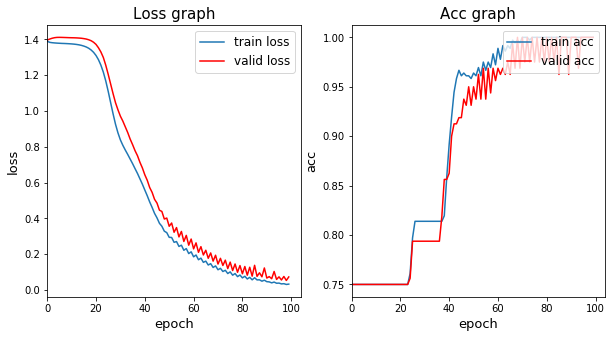

In [22]:
#Loss graph
%matplotlib inline

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,2,1)
ax.plot(train_history['loss'].tolist(), label='train loss')
ax.plot(valid_history['loss'].tolist(), label='valid loss', color='Red')

#ax.plot( range(val_freq, len(train_history)+val_freq, val_freq), valid_history['loss'], label='valid loss', marker='o', color='Red')
#ax.axis([0, len(train_history), 0, 1.0])
plt.xlim(0,None)
plt.legend(fontsize=12, loc='upper right')
plt.title('Loss graph', fontsize=15)
plt.xlabel('epoch', fontsize=13)
plt.ylabel('loss', fontsize=13)

plt.savefig(os.path.join(save_path, model_name, 'loss_graph.png'))

ax = fig.add_subplot(1,2,2)
ax.plot(train_history['acc'].tolist(), label='train acc')
ax.plot(valid_history['acc'].tolist(), label='valid acc', color='Red')

#ax.plot( range(val_freq, len(train_history)+val_freq, val_freq), valid_history['loss'], label='valid loss', marker='o', color='Red')
#ax.axis([0, len(train_history), 0, 1.0])
plt.xlim(0,None)
plt.legend(fontsize=12, loc='upper right')
plt.title('Acc graph', fontsize=15)
plt.xlabel('epoch', fontsize=13)
plt.ylabel('acc', fontsize=13)


plt.savefig(os.path.join(save_path, model_name, 'acc_graph.png'))


In [23]:
bestepoch = int(np.argmin(valid_history['loss']))

/usr/local/lib/python3.5/dist-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


In [24]:
error = valid_history.loc[bestepoch,'loss']
print ("error: {}".format(error))

error: 0.05379404965788126


In [25]:
bestepoch=bestepoch
MC_dropout_model.load(os.path.join(save_path, model_name,str(bestepoch)+'.ckpt'))

INFO:tensorflow:Restoring parameters from ./savedmodel/ICML(UCR-Trace)_CNN_MCdropout_0.001_10/98.ckpt
Model restored


### with confusion matrix

In [26]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    fig=plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)

    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt =  'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
    plt.subplot(122)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' 
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    plt.tight_layout()
    plt.show()

In [27]:
class_list = np.unique(y_train, return_counts=False, return_index=True)[0].astype(int)

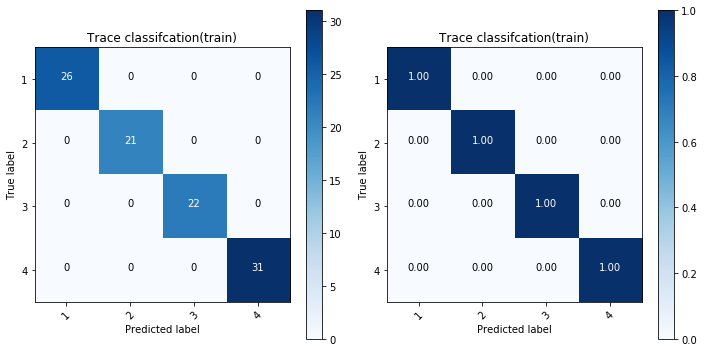

In [28]:
prediction = MC_dropout_model.predict(data=trainX,keep_prob=1.0,is_dropout=False)
prediction = np.argmax(prediction,axis=1)
target = np.argmax(trainY,axis=1)

plot_confusion_matrix(confusion_matrix(prediction,target),                      
    classes=class_list,
    title=fname+' classifcation(train)')

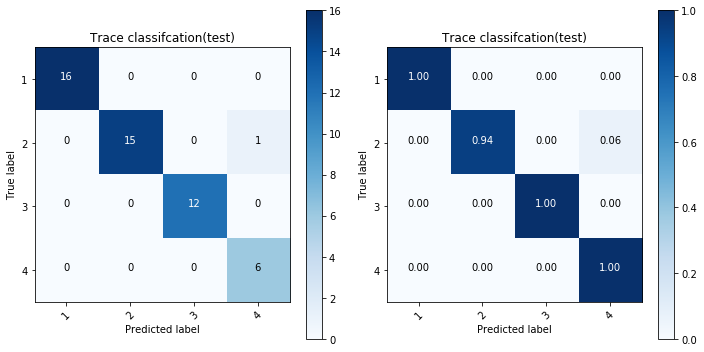

In [29]:
prediction = MC_dropout_model.predict(data=testX,keep_prob=1.0,is_dropout=False)
prediction = np.argmax(prediction,axis=1)
target = np.argmax(testY,axis=1)

plot_confusion_matrix(confusion_matrix(prediction,target),                      
    classes=class_list,
    title=fname+' classifcation(test)')

# 5. Trained 된 모델에서 Last Conv output Load하기(MC dropout적용안됨)

In [30]:
threshold = 0.2
focused_conv_channel = 11

In [31]:
#trainX를 인풋으로 넣었을 때, last conv layer 의 focused_conv_channel output 보기
last_conv_output1 = MC_dropout_model.get_last_conv_output(data=trainX,keep_prob=1.0,is_dropout=False)[:,0,:,focused_conv_channel]
last_conv_bool1 = last_conv_output1>threshold

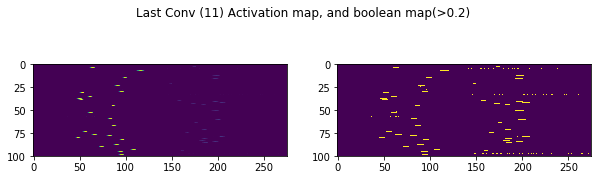

In [32]:
#각 한줄당 한 데이터에 대한 activation function 및 threshold를 넘은 부분
fig = plt.figure(figsize=(10,3))
fig.suptitle("Last Conv ({}) Activation map, and boolean map(>{})".format(focused_conv_channel, threshold))
ax = plt.subplot(1,2,1)
ax.imshow(last_conv_output1)
ax = plt.subplot(1,2,2)
ax.imshow(last_conv_bool1)

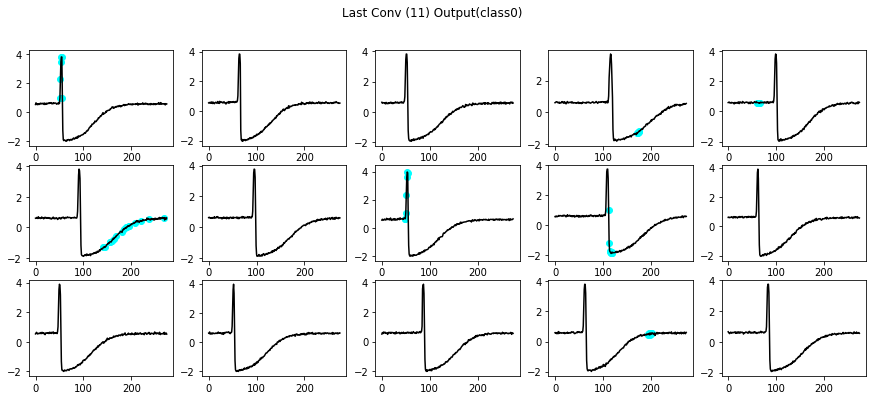

In [33]:
focused_label = 0

fig = plt.figure(figsize=(15,6))
fig.suptitle("Last Conv ({}) Output(class{}) ".format(focused_conv_channel,focused_label))
pattern =[]
for i,x in enumerate(trainX[np.argmax(trainY,axis=1) == focused_label]):
    ax = plt.subplot(3,5,i+1)
    data = x.reshape(-1,1)
    pattern_idx = [i for i, x in enumerate(last_conv_bool1[i]) if x]
    ax.plot(data,color='black')
    if pattern_idx:
        ax.scatter(pattern_idx, data[pattern_idx],color = "cyan")
    if i==14:
        break

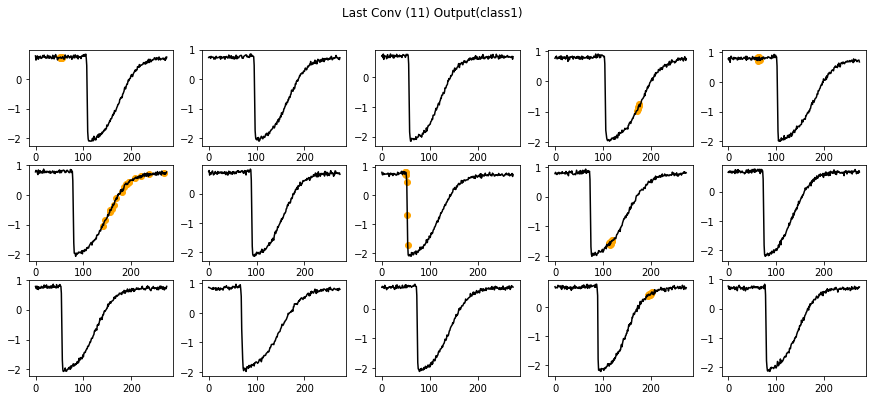

In [34]:
focused_label=1

fig = plt.figure(figsize=(15,6))
fig.suptitle("Last Conv ({}) Output(class{}) ".format(focused_conv_channel,focused_label))
pattern =[]
for i,x in enumerate(trainX[np.argmax(trainY,axis=1) == focused_label]):
    ax = plt.subplot(3,5,i+1)
    data = x.reshape(-1,1)
    pattern_idx = [i for i, x in enumerate(last_conv_bool1[i]) if x]
    ax.plot(data,color='black')
    if pattern_idx:
        ax.scatter(pattern_idx, data[pattern_idx],color = "orange")
    if i==14:
        break

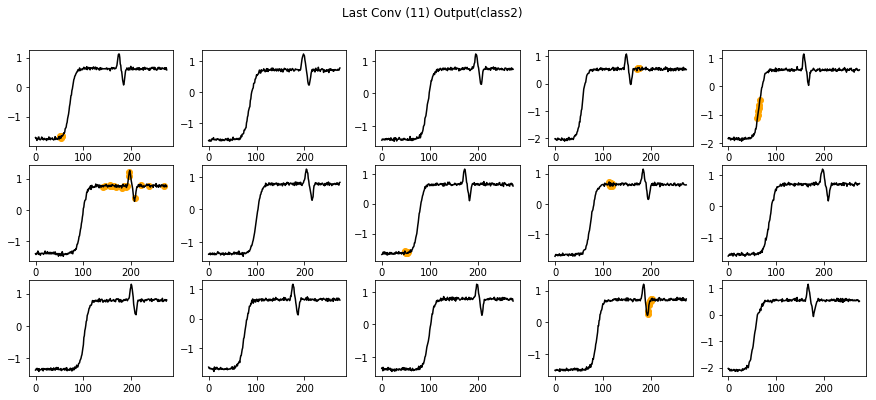

In [35]:
focused_label=2

fig = plt.figure(figsize=(15,6))
fig.suptitle("Last Conv ({}) Output(class{}) ".format(focused_conv_channel,focused_label))
pattern =[]
for i,x in enumerate(trainX[np.argmax(trainY,axis=1) == focused_label]):
    ax = plt.subplot(3,5,i+1)
    data = x.reshape(-1,1)
    pattern_idx = [i for i, x in enumerate(last_conv_bool1[i]) if x]
    ax.plot(data,color='black')
    if pattern_idx:
        ax.scatter(pattern_idx, data[pattern_idx],color = "orange")
    if i==14:
        break

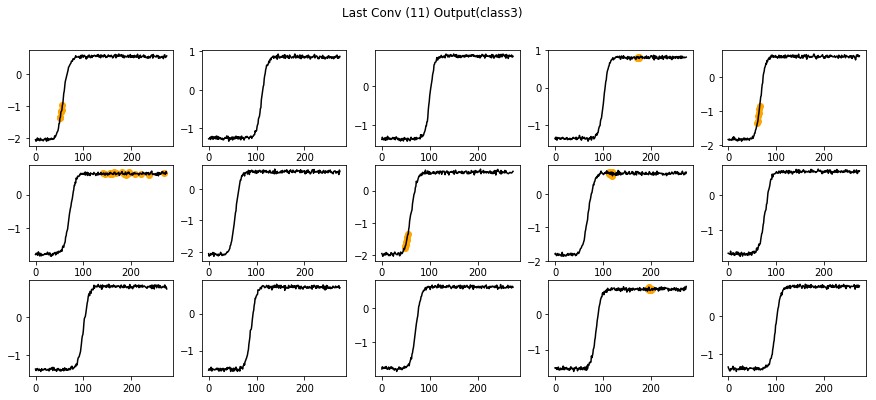

In [36]:
focused_label=3

fig = plt.figure(figsize=(15,6))
fig.suptitle("Last Conv ({}) Output(class{}) ".format(focused_conv_channel,focused_label))
pattern =[]
for i,x in enumerate(trainX[np.argmax(trainY,axis=1) == focused_label]):
    ax = plt.subplot(3,5,i+1)
    data = x.reshape(-1,1)
    pattern_idx = [i for i, x in enumerate(last_conv_bool1[i]) if x]
    ax.plot(data,color='black')
    if pattern_idx:
        ax.scatter(pattern_idx, data[pattern_idx],color = "orange")
    if i==14:
        break

## MC dropout을 적용한 패턴

In [37]:
#trainX를 인풋으로 넣었을 때, last conv layer 의 focused_conv_channel output 보기
last_conv_output1 = MC_dropout_model.get_last_conv_output(data=trainX,keep_prob=0.5,is_dropout=True)[:,0,:,focused_conv_channel]
last_conv_bool1 = last_conv_output1>threshold

In [38]:
last_conv_output1

array([[0.        , 0.        , 0.        , ..., 0.25667712, 0.        ,
        0.08499458],
       [0.        , 0.        , 0.39084226, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.07912369,
        0.04515945],
       ...,
       [0.        , 0.        , 0.        , ..., 0.6420188 , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.15266095, 0.        ,
        0.        ],
       [0.63408947, 0.        , 0.31481403, ..., 0.        , 0.40476233,
        0.        ]], dtype=float32)

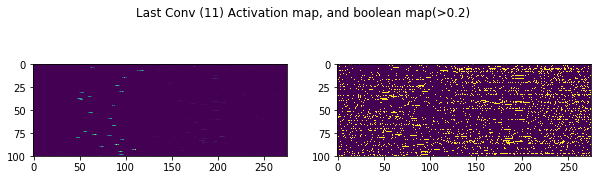

In [39]:
#각 한줄당 한 데이터에 대한 activation function 및 threshold를 넘은 부분
fig = plt.figure(figsize=(10,3))
fig.suptitle("Last Conv ({}) Activation map, and boolean map(>{})".format(focused_conv_channel, threshold))
ax = plt.subplot(1,2,1)
ax.imshow(last_conv_output1)

ax = plt.subplot(1,2,2)
ax.imshow(last_conv_bool1)

In [40]:
# prediction 시에는 MC dropout 을 적용
# keep_prob = 0.5(survive 확률) , dropout_bool=True

#각 데이터 마다 MC dropout 을 B 번 적용한다면, B 개의 서로 다른 model structure를 거치며 나타난 last conv output을 각 노드마다 모두 저장해놓음

#데이터가 N 개이고, MC dropout 횟수가 B번이라면, 총 N*B개의 패턴이 저장됨
#pattern_idx 에는 각 인풋마다 B번의 MC dropout했을 때, highlight되는 데이터의 인덱스를 저장

pattern_idx = []
B = 2

for X in trainX:
    X = np.expand_dims(X,0) # (height,width,channel) --> (1,height,width,channel)
    # 한 데이터에 대해서 B 번의 dropout을 적용
    for i in range(0,B):
        last_conv_output = MC_dropout_model.get_last_conv_output(data=X,keep_prob=0.5,is_dropout=True)[:,0,:,focused_conv_channel]
        last_conv_bool = last_conv_output1>threshold
        pattern_idx.append([i for i, x in enumerate(last_conv_bool[0]) if x])

# 9. CAM(MC dropout: X)

In [41]:
# getting last_conv
relu3 = MC_dropout_model.sess.run((MC_dropout_model.relu3),
                                   feed_dict={MC_dropout_model.x: testX[:100],
                                              MC_dropout_model.keep_prob: 1.0,
                                              MC_dropout_model.is_dropout : False})
# getting softmax
logits = MC_dropout_model.sess.run((MC_dropout_model.logits),
                                   feed_dict={MC_dropout_model.x: testX[:100],
                                              MC_dropout_model.keep_prob: 1.0,
                                              MC_dropout_model.is_dropout : False})
# getting softmax weights
weight = MC_dropout_model.sess.run((tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)[-2]),
                                   feed_dict ={MC_dropout_model.x: testX[:100],
                                               MC_dropout_model.keep_prob: 1.0,
                                               MC_dropout_model.is_dropout : False})

In [42]:
# getting CAM
CAM = np.dot(relu3, weight)

In [43]:
# prepro.
CAM = (CAM - CAM.min(axis=2, keepdims=True)) / (CAM.max(axis=2, keepdims=True) - CAM.min(axis=2, keepdims=True))
c = np.exp(CAM) / np.sum(np.exp(CAM), axis=2, keepdims=True)

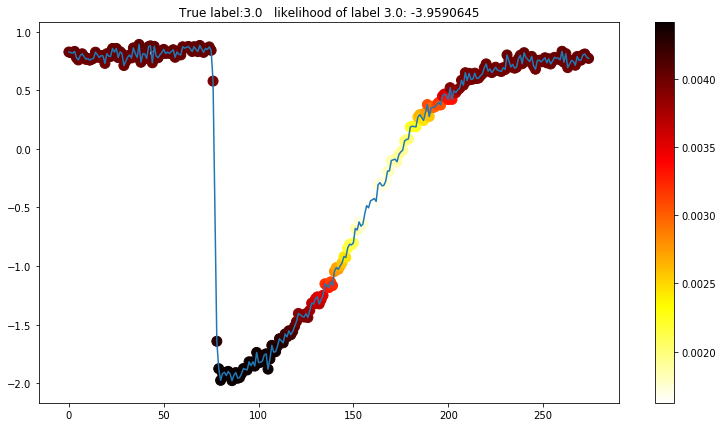

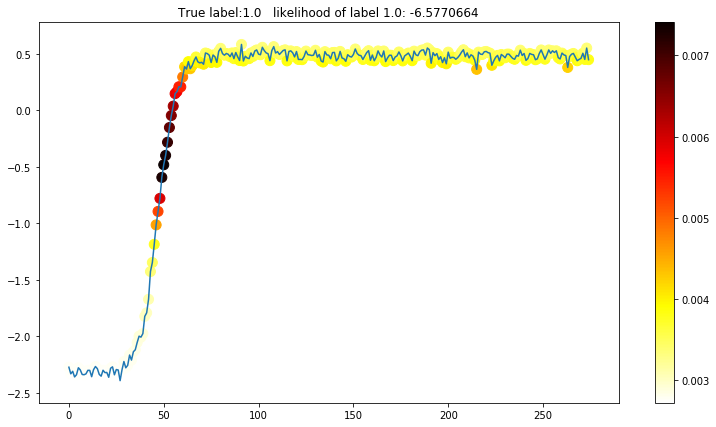

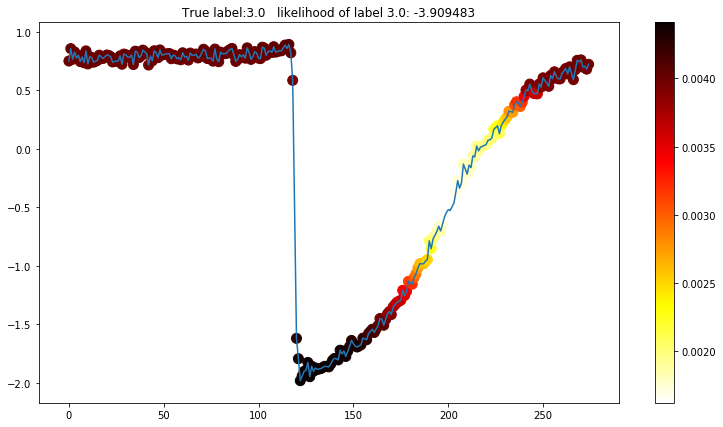

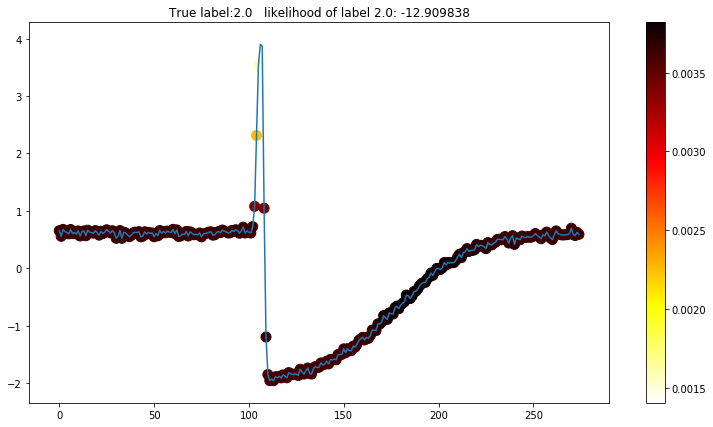

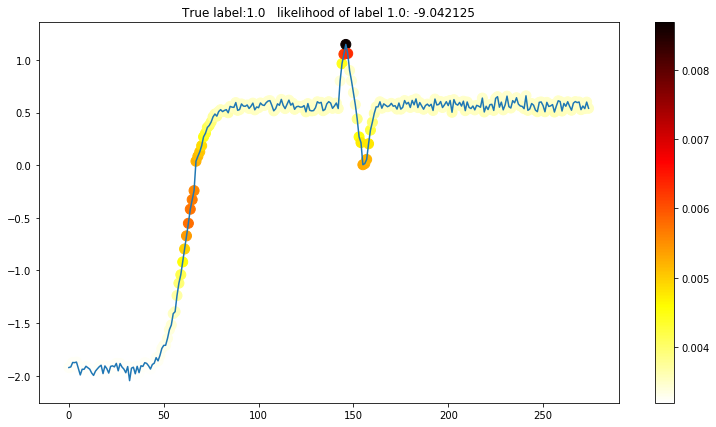

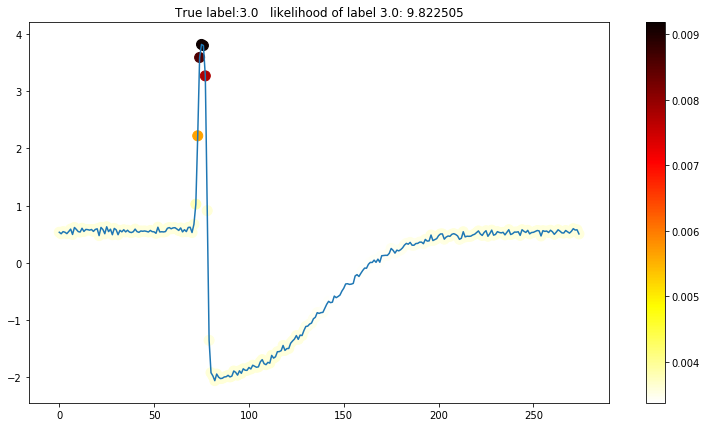

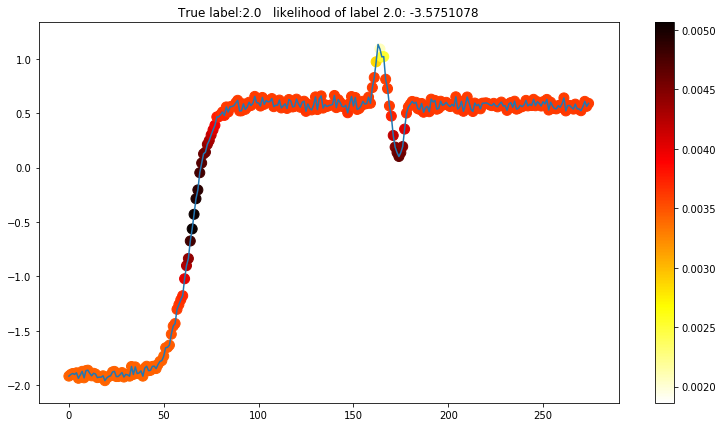

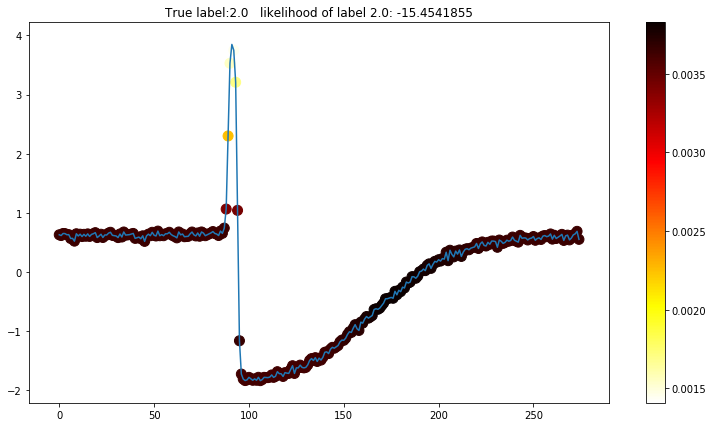

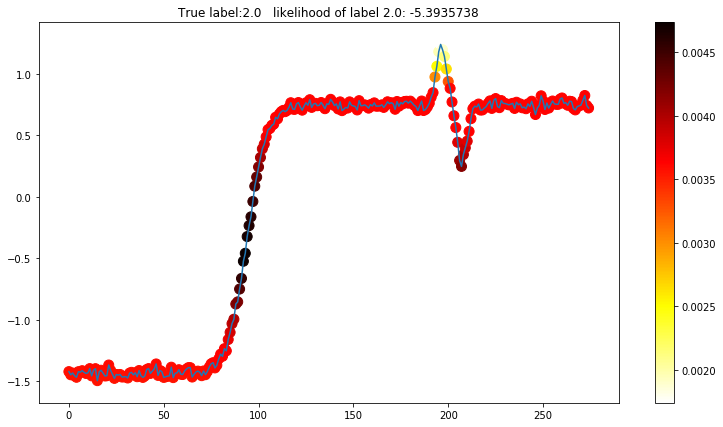

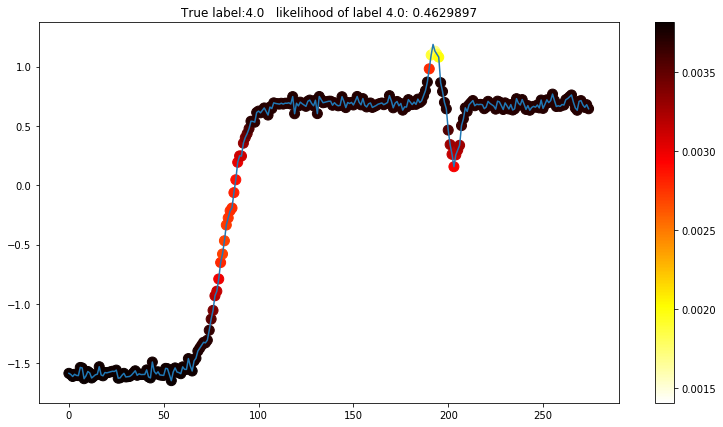

In [44]:
# plot
for k in range(10):
    plt.figure(figsize=(13, 7));
    plt.plot(testX[k].squeeze());
    plt.scatter(np.arange(len(testX[0,0,:,0])),
                testX[k].squeeze(),
                cmap='hot_r',
                c=c[k, :, :, int(y_test[k])-1].squeeze(),                
                s=100);
    plt.title('True label:' + str(y_test[k]) + '   likelihood of label ' + str(y_test[k]) + ': ' + str(logits[k][int(y_test[k])-1]))
    plt.colorbar();

# CAM(MC dropout: O)

In [45]:
# getting last_conv
relu3 = MC_dropout_model.sess.run((MC_dropout_model.relu3),
                                   feed_dict={MC_dropout_model.x: testX[:100],
                                              MC_dropout_model.keep_prob: 0.5,
                                              MC_dropout_model.is_dropout : True})
# getting softmax
logits = MC_dropout_model.sess.run((MC_dropout_model.logits),
                                   feed_dict={MC_dropout_model.x: testX[:100],
                                              MC_dropout_model.keep_prob: 0.5,
                                              MC_dropout_model.is_dropout : True})
# getting softmax weights
weight = MC_dropout_model.sess.run((tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)[-2]),
                                   feed_dict ={MC_dropout_model.x: testX[:100],
                                               MC_dropout_model.keep_prob: 0.5,
                                               MC_dropout_model.is_dropout : True})

In [46]:
# getting CAM
CAM = np.dot(relu3, weight)

In [47]:
# prepro.
CAM = (CAM - CAM.min(axis=2, keepdims=True)) / (CAM.max(axis=2, keepdims=True) - CAM.min(axis=2, keepdims=True))
c = np.exp(CAM) / np.sum(np.exp(CAM), axis=2, keepdims=True)

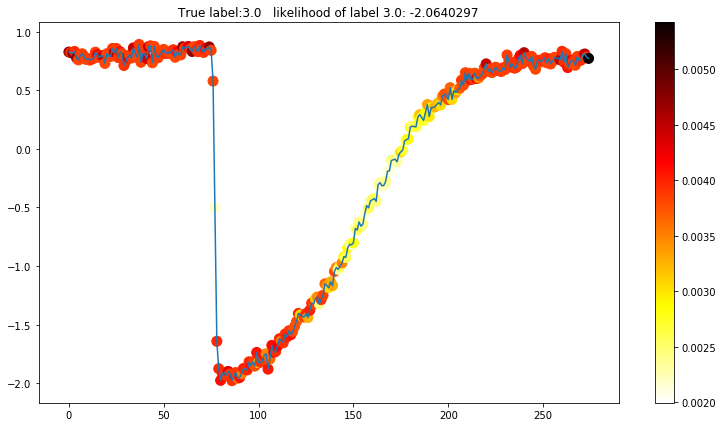

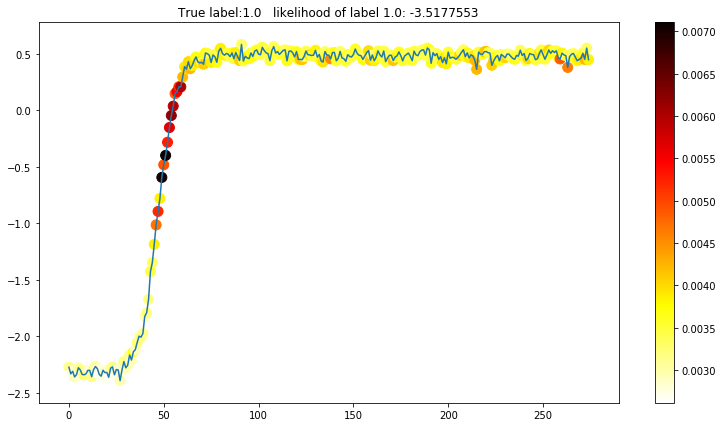

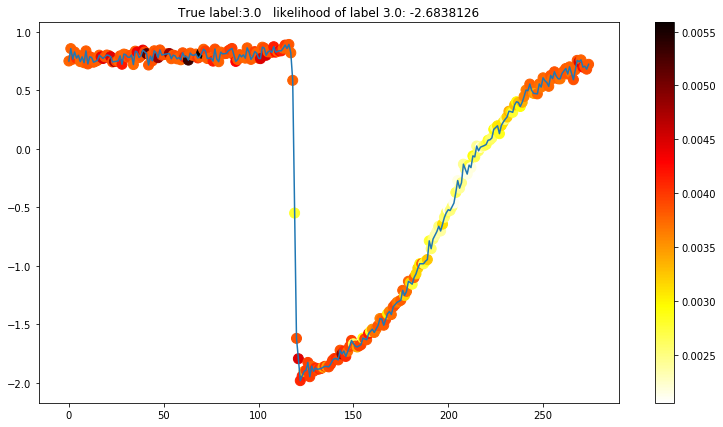

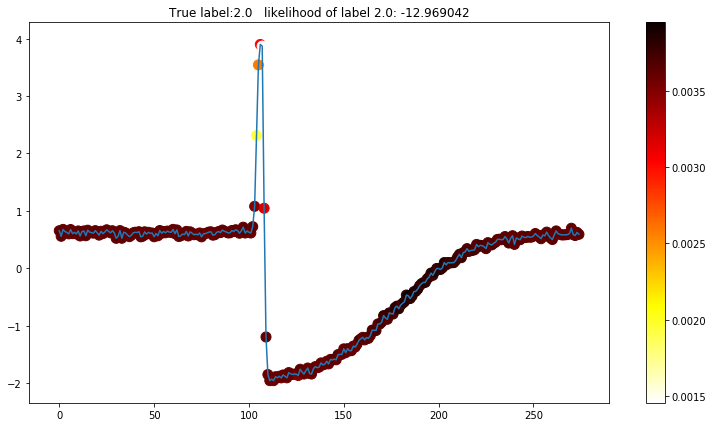

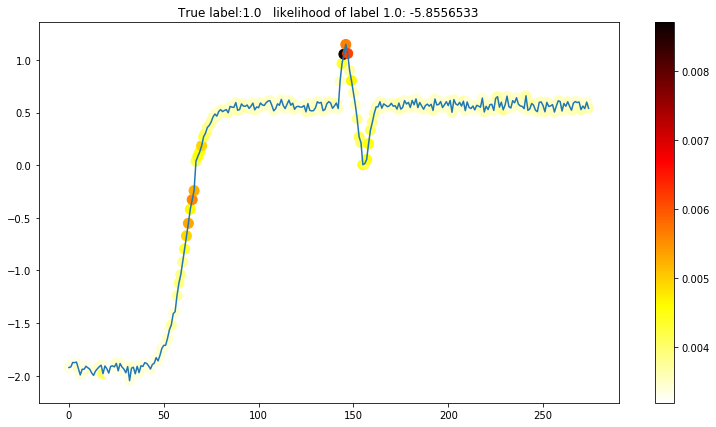

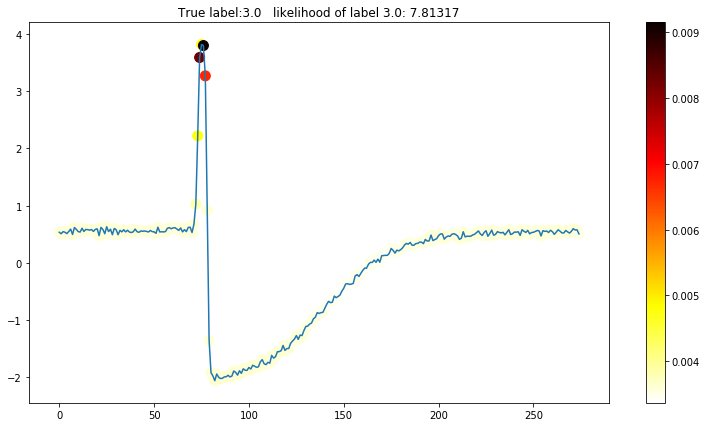

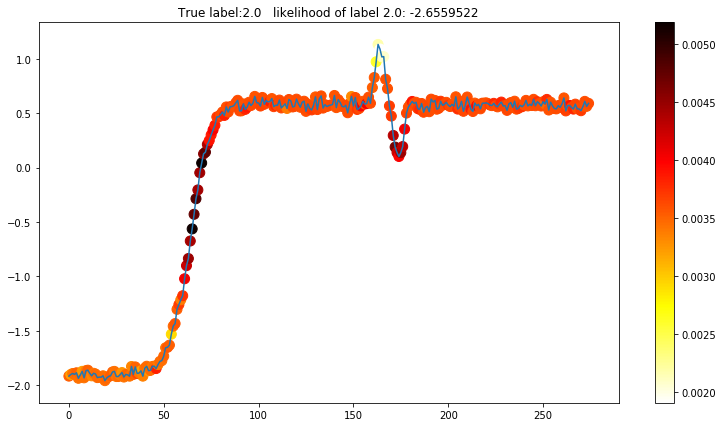

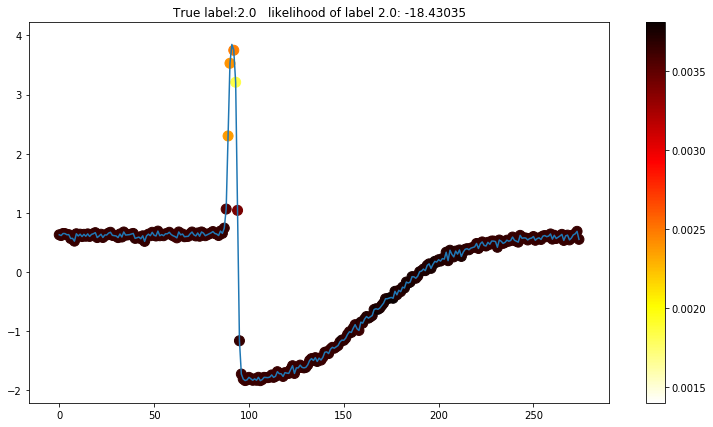

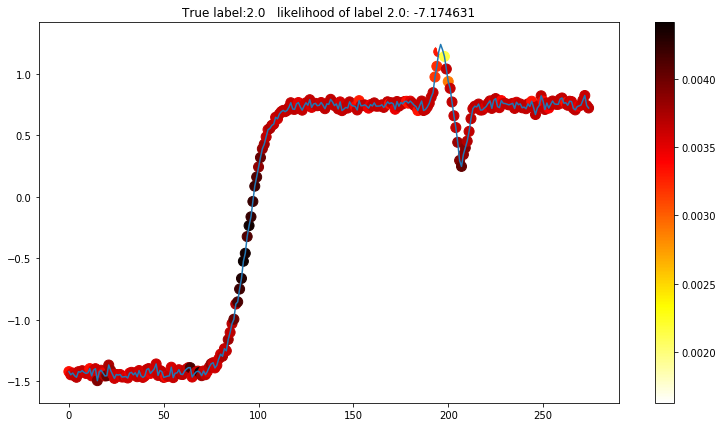

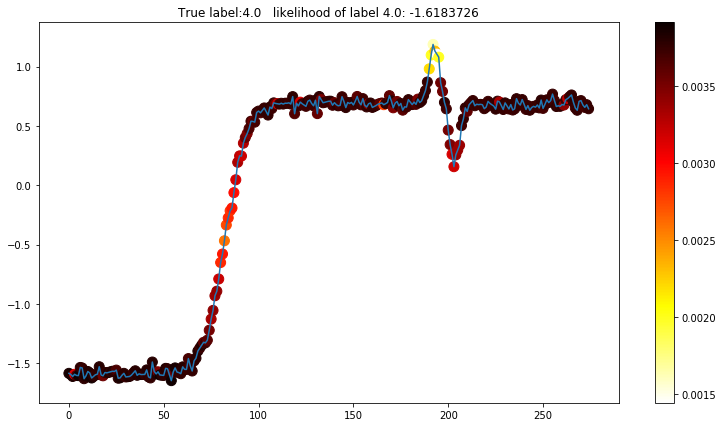

In [48]:
# plot
for k in range(10):
    plt.figure(figsize=(13, 7));
    plt.plot(testX[k].squeeze());
    plt.scatter(np.arange(len(testX[0,0,:,0])),
                testX[k].squeeze(),
                cmap='hot_r',
                c=c[k, :, :, int(y_test[k])-1].squeeze(),                
                s=100);
    plt.title('True label:' + str(y_test[k]) + '   likelihood of label ' + str(y_test[k]) + ': ' + str(logits[k][int(y_test[k])-1]))
    plt.colorbar();